In [515]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-movies-india/IMDb Movies India.csv
/kaggle/input/imdb-rating-prediction-model/IMDb Movies India.csv


In [516]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
from xgboost import XGBRegressor
import optuna
import shap
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.style.use("ggplot")

import warnings
warnings.filterwarnings("ignore")

In [517]:

import pandas as pd

# Load the dataset
df = pd.read_csv('/kaggle/input/imdb-rating-prediction-model/IMDb Movies India.csv', encoding='ISO-8859-1')

# Drop the 'Name' column if it exists
df.drop(columns='Name', errors='ignore', inplace=True)

# Remove rows with missing values
df.dropna(inplace=True)

# Display the first few rows of the dataframe
df.head()


,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,(1997),147 min,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,(2005),142 min,"Drama, Romance, War",7.4,"1,086",Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,(2012),82 min,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


In [518]:
# Find info about the columns
print(df.shape)
print("-"*60)
print(df.isna().sum())
print("-"*60)
print(df.duplicated().sum())
print("-"*60)
df.info()

(5659, 9)
------------------------------------------------------------
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64
------------------------------------------------------------
0
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 5659 entries, 1 to 15508
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      5659 non-null   object 
 1   Duration  5659 non-null   object 
 2   Genre     5659 non-null   object 
 3   Rating    5659 non-null   float64
 4   Votes     5659 non-null   object 
 5   Director  5659 non-null   object 
 6   Actor 1   5659 non-null   object 
 7   Actor 2   5659 non-null   object 
 8   Actor 3   5659 non-null   object 
dtypes: float64(1), object(8)
memory usage: 442.1+ KB


In [519]:
# Check the basic info of the dataframe (e.g., number of rows, columns, and data types)
df.info()

# Check for any duplicate rows in the dataframe
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Remove duplicate rows if any
df.drop_duplicates(inplace=True)

# Check for missing values again after dropping duplicates
missing_values = df.isnull().sum()
print(f"Missing values after removing duplicates:\n{missing_values}")

# Explore basic statistics for numerical columns
df.describe()

# Display the first few rows of the dataframe after cleaning
df.head()


<class 'pandas.core.frame.DataFrame'>
Index: 5659 entries, 1 to 15508
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      5659 non-null   object 
 1   Duration  5659 non-null   object 
 2   Genre     5659 non-null   object 
 3   Rating    5659 non-null   float64
 4   Votes     5659 non-null   object 
 5   Director  5659 non-null   object 
 6   Actor 1   5659 non-null   object 
 7   Actor 2   5659 non-null   object 
 8   Actor 3   5659 non-null   object 
dtypes: float64(1), object(8)
memory usage: 442.1+ KB
Number of duplicate rows: 0
Missing values after removing duplicates:
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64


,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,(1997),147 min,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,(2005),142 min,"Drama, Romance, War",7.4,"1,086",Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,(2012),82 min,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


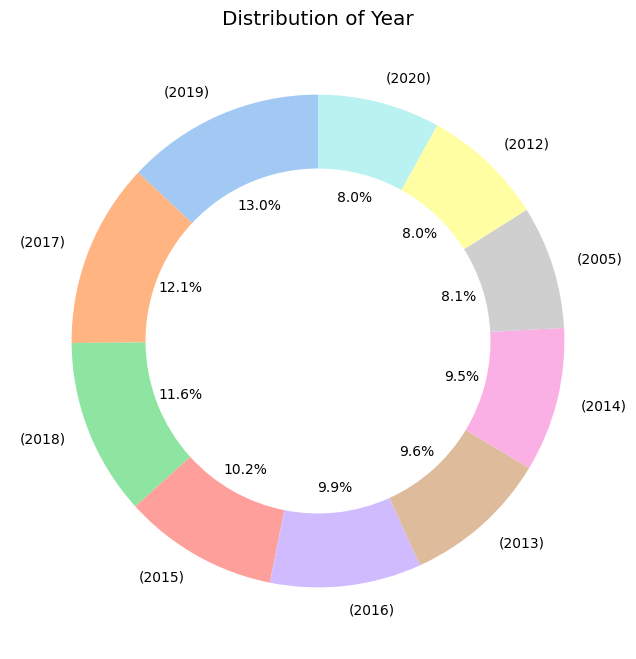

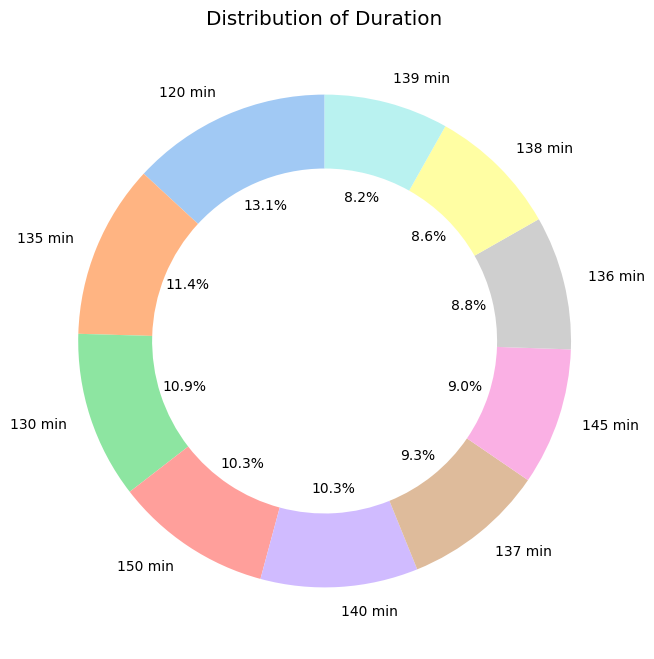

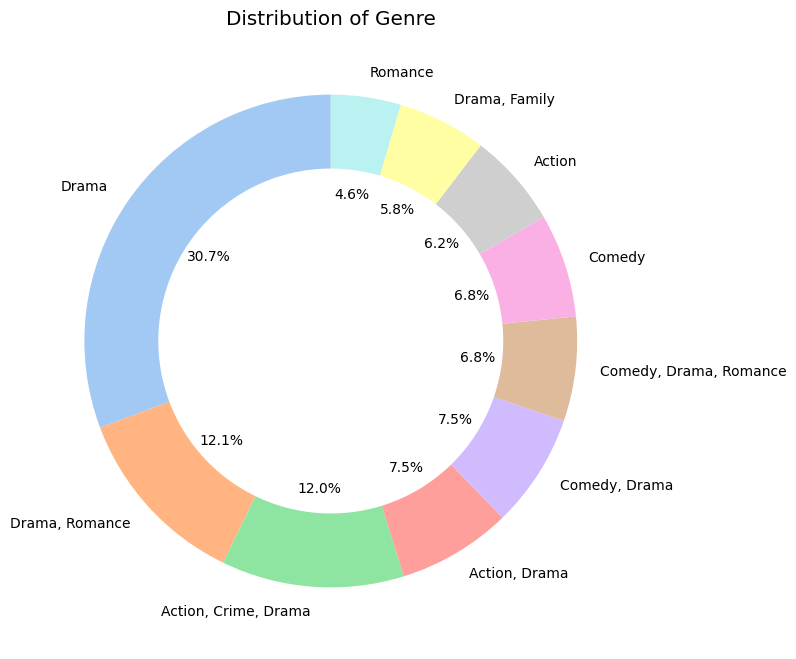

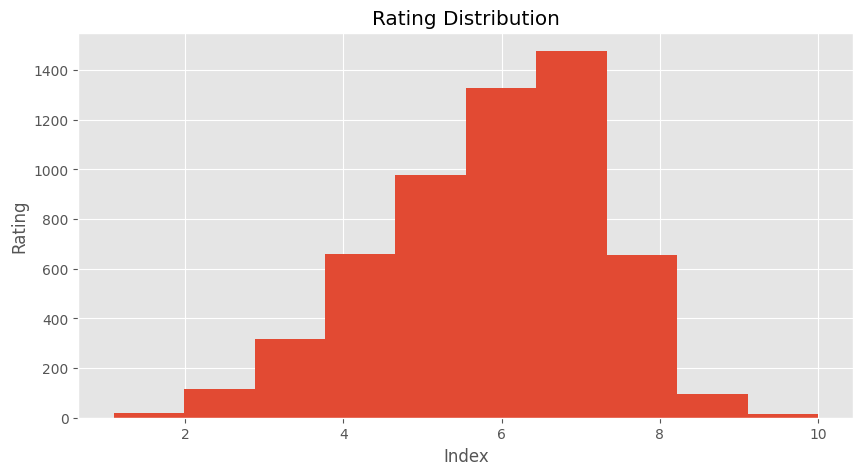

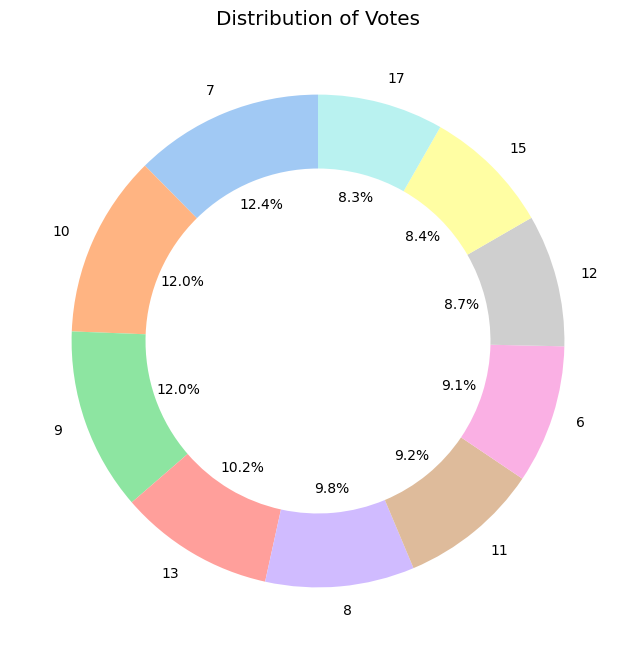

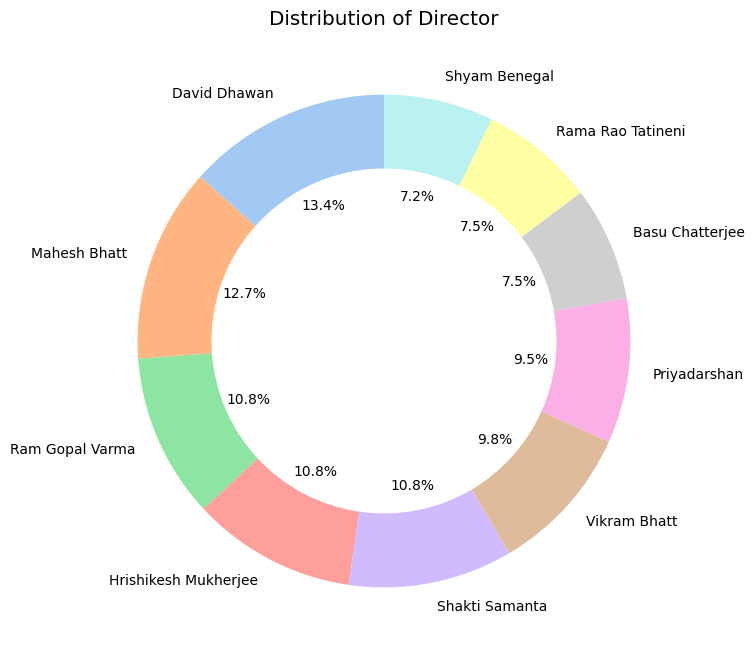

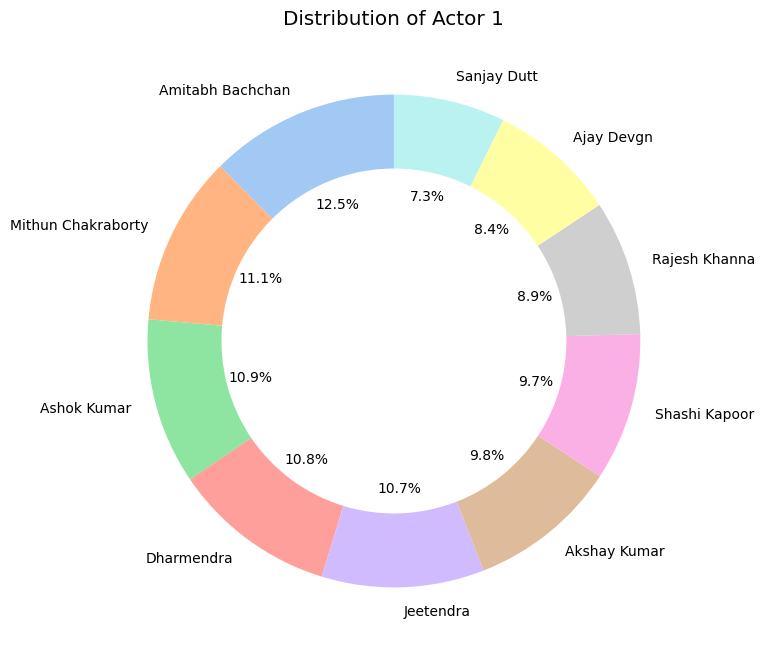

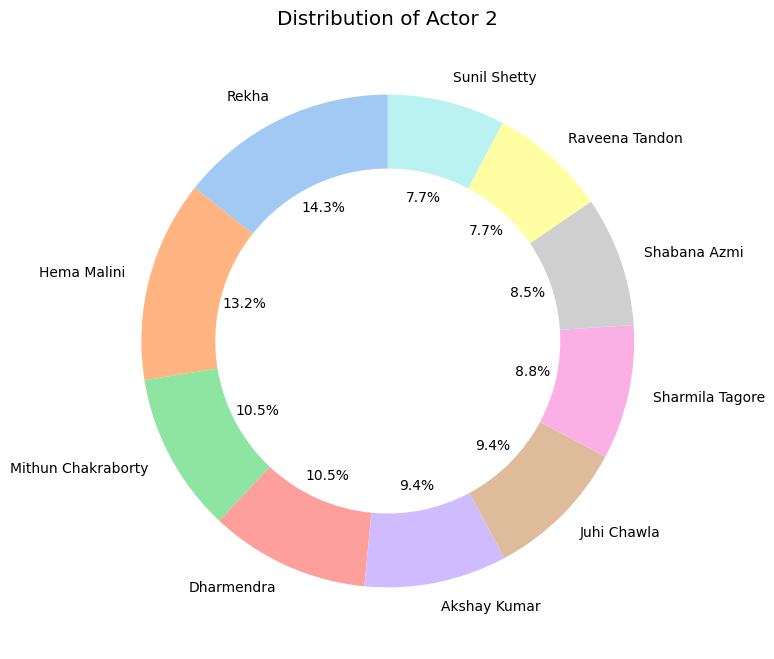

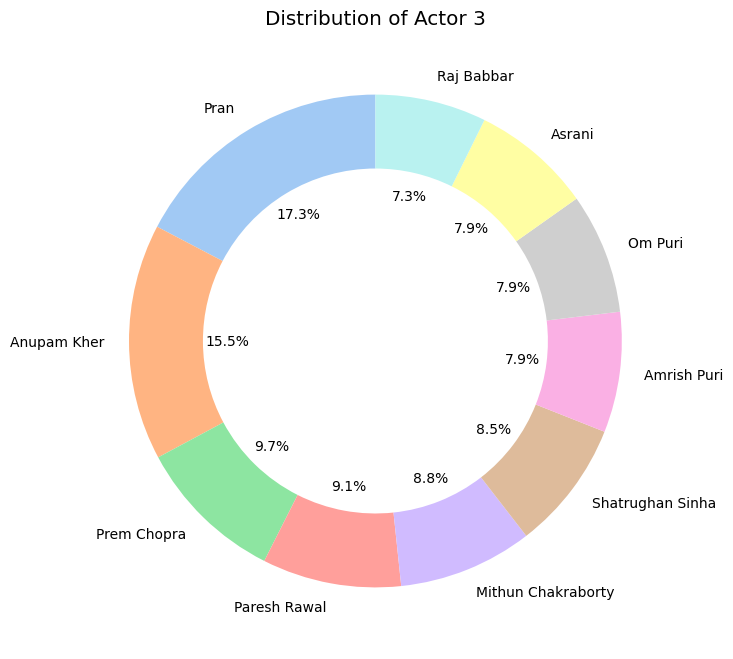

In [520]:
# Function to plot pie chart
def plot_pie_chart(column):
    plt.figure(figsize=(8, 8))
    df[column].value_counts().head(10).plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'), wedgeprops=dict(width=0.3))
    plt.title(f'Distribution of {column}')
    plt.ylabel('')
    plt.show()
    
    
def plot_hist_chart(column):
    plt.figure(figsize=(10, 5))
    df[column].hist()
    plt.title(f'{column} Distribution')
    plt.xlabel('Index')
    plt.ylabel(column)
    plt.show()

# Plotting for each column
for col in df.columns:
    if df[col].dtype == 'object':
        plot_pie_chart(col)
    else:
        plot_hist_chart(col)

In [521]:
# Remove () and convert dtype if year to int 
df['Year'] = df['Year'].str.replace('(','')
df['Year'] = df['Year'].str.replace(')','').astype(int)

df['Duration'] = df['Duration'].str.split(' ',expand=True)[0].astype(float)

df['Votes'] = df['Votes'].str.replace(',','').astype(int)

df

,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,2019,109.0,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,2019,110.0,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,1997,147.0,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,2005,142.0,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,2012,82.0,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia
...,...,...,...,...,...,...,...,...,...
15493,2015,115.0,Drama,6.1,408,Mozez Singh,Vicky Kaushal,Sarah Jane Dias,Raaghavv Chanana
15494,2001,153.0,"Biography, Drama, History",6.2,1496,Shyam Benegal,Karisma Kapoor,Rekha,Manoj Bajpayee
15503,1989,125.0,"Action, Crime, Drama",5.8,44,S.P. Muthuraman,Chiranjeevi,Jayamalini,Rajinikanth
15505,1999,129.0,"Action, Drama",4.5,655,Kuku Kohli,Akshay Kumar,Twinkle Khanna,Aruna Irani


In [522]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/kaggle/input/imdb-rating-prediction-model/IMDb Movies India.csv', encoding='ISO-8859-1')

# Drop the 'Name' column if it exists
df.drop(columns='Name', errors='ignore', inplace=True)

# Remove rows with missing values
df.dropna(inplace=True)

# Calculate the average IMDb rating for each director
director_avg_rating = df.groupby('Director')['Rating'].transform('mean')

# Assign the calculated average rating to a new column
df['Director Average Rating'] = director_avg_rating

# Display the first few rows of the dataframe to verify the new column
df.head()


,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Director Average Rating
1,(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,7.000000
3,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,4.400000
5,(1997),147 min,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor,5.313333
6,(2005),142 min,"Drama, Romance, War",7.4,"1,086",Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma,7.383333
8,(2012),82 min,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia,5.600000


In [523]:
director_avg_rating = {}
for index, row in df.iterrows():
    director = row['Director']
    rating = row['Rating']
    if director in director_avg_rating:
        director_avg_rating[director]['sum'] += rating
        director_avg_rating[director]['count'] += 1
    else:
        director_avg_rating[director] = {'sum': rating, 'count': 1}

df['Director Average Rating'] = df['Director'].apply(lambda x: director_avg_rating[x]['sum'] / director_avg_rating[x]['count'])

In [524]:
# add a column ''ead actor average rating'
actor_avg_rating = {}
for index, row in df.iterrows():
    actors = row['Actor 1'].split(', ')
    rating = row['Rating']
    for actor in actors:
        if actor in actor_avg_rating:
            actor_avg_rating[actor]['sum'] += rating
            actor_avg_rating[actor]['count'] += 1
        else:
            actor_avg_rating[actor] = {'sum': rating, 'count': 1}
            
def calculate_lead_actor_average(row):
    actors = row['Actor 1'].split(', ')
    lead_actor_ratings = [actor_avg_rating[actor]['sum'] / actor_avg_rating[actor]['count'] for actor in actors]
    return max(lead_actor_ratings)

df['Lead Actor Average Rating'] = df.apply(calculate_lead_actor_average, axis=1)

In [525]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/kaggle/input/imdb-rating-prediction-model/IMDb Movies India.csv', encoding='ISO-8859-1')

# Drop the 'Name' column if it exists
df.drop(columns='Name', errors='ignore', inplace=True)

# Remove rows with missing values
df.dropna(inplace=True)

# Calculate the average IMDb rating for each director
director_avg_rating = df.groupby('Director')['Rating'].mean()

# Assign the calculated average rating to a new column for each movie
df['Director Average Rating'] = df['Director'].map(director_avg_rating)

# Create a dictionary to store actor ratings
actor_avg_rating = {}

# Loop through each row and calculate the average rating for each actor
for index, row in df.iterrows():
    actors = row['Actor 1'].split(', ')
    rating = row['Rating']
    for actor in actors:
        if actor in actor_avg_rating:
            actor_avg_rating[actor]['sum'] += rating
            actor_avg_rating[actor]['count'] += 1
        else:
            actor_avg_rating[actor] = {'sum': rating, 'count': 1}

# Function to calculate the lead actor's average rating for each movie
def calculate_lead_actor_average(row):
    actors = row['Actor 1'].split(', ')
    lead_actor_ratings = [actor_avg_rating[actor]['sum'] / actor_avg_rating[actor]['count'] for actor in actors]
    return max(lead_actor_ratings)

# Apply the function to create the 'Lead Actor Average Rating' column
df['Lead Actor Average Rating'] = df.apply(calculate_lead_actor_average, axis=1)

# Display the first few rows of the dataframe to verify the new columns
df.head()


,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Director Average Rating,Lead Actor Average Rating
1,(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,7.000000,6.850000
3,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,4.400000,5.420000
5,(1997),147 min,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor,5.313333,4.788889
6,(2005),142 min,"Drama, Romance, War",7.4,"1,086",Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma,7.383333,5.435000
8,(2012),82 min,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia,5.600000,5.600000


In [526]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/kaggle/input/imdb-rating-prediction-model/IMDb Movies India.csv', encoding='ISO-8859-1')

# Drop the 'Name' column if it exists
df.drop(columns='Name', errors='ignore', inplace=True)

# Remove rows with missing values
df.dropna(inplace=True)

# Extract the first, second, and third genres into separate columns
df['Genre1'] = df['Genre'].str.split(',', expand=True)[0]
df['Genre2'] = df['Genre'].str.split(',', expand=True)[1]
df['Genre3'] = df['Genre'].str.split(',', expand=True)[2]

# Drop the unnecessary columns
df = df.drop(columns=['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3'])

# Display the shape of the DataFrame
print(df.shape[0])


5659


In [527]:
print(df.shape)
print(df.isna().sum())
df = df.fillna(0)

for i in df.index:
    if df.at[i, 'Genre2'] == 0:
        df.at[i, 'Genre2'] = df.at[i, 'Genre1']
    elif df.at[i, 'Genre3'] == 0:
        df.at[i, 'Genre3'] = df.at[i, 'Genre2']
print(df.isna().sum())

(5659, 7)
Year           0
Duration       0
Rating         0
Votes          0
Genre1         0
Genre2      1658
Genre3      3340
dtype: int64
Year        0
Duration    0
Rating      0
Votes       0
Genre1      0
Genre2      0
Genre3      0
dtype: int64


In [528]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5659 entries, 1 to 15508
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      5659 non-null   object 
 1   Duration  5659 non-null   object 
 2   Rating    5659 non-null   float64
 3   Votes     5659 non-null   object 
 4   Genre1    5659 non-null   object 
 5   Genre2    5659 non-null   object 
 6   Genre3    5659 non-null   object 
dtypes: float64(1), object(6)
memory usage: 482.7+ KB


In [529]:
for col in ['Genre1', 'Genre2', 'Genre3']:
    df[col], _ = pd.factorize(df[col])

df.head()

,Year,Duration,Rating,Votes,Genre1,Genre2,Genre3
1,(2019),109 min,7.0,8,0,0,0
3,(2019),110 min,4.4,35,1,1,1
5,(1997),147 min,4.7,827,1,2,2
6,(2005),142 min,7.4,"1,086",0,1,3
8,(2012),82 min,5.6,326,2,3,4


In [530]:
df.shape

(5659, 7)

In [531]:
df.Year.unique()

array(['(2019)', '(1997)', '(2005)', '(2012)', '(2014)', '(2004)',
       '(2016)', '(1991)', '(2018)', '(2010)', '(1958)', '(2021)',
       '(2017)', '(2009)', '(1993)', '(2002)', '(2008)', '(1994)',
       '(2007)', '(2003)', '(1998)', '(1979)', '(1974)', '(2015)',
       '(2006)', '(1981)', '(2020)', '(1985)', '(2013)', '(2011)',
       '(1988)', '(1987)', '(1999)', '(1973)', '(1968)', '(1982)',
       '(1977)', '(1950)', '(1969)', '(1948)', '(1990)', '(1989)',
       '(2001)', '(2000)', '(1953)', '(1978)', '(1963)', '(1992)',
       '(1976)', '(1984)', '(1986)', '(1966)', '(1975)', '(1980)',
       '(1967)', '(1970)', '(1952)', '(1972)', '(1971)', '(1964)',
       '(1954)', '(1962)', '(1957)', '(1965)', '(1996)', '(1995)',
       '(1956)', '(1955)', '(1936)', '(1983)', '(1951)', '(1961)',
       '(1959)', '(1949)', '(1960)', '(1946)', '(1940)', '(1945)',
       '(1938)', '(1941)', '(1942)', '(1935)', '(1937)', '(1947)',
       '(1931)', '(1933)', '(1943)', '(1944)', '(1932)', '(193

In [532]:
df.Rating.unique()  

array([ 7. ,  4.4,  4.7,  7.4,  5.6,  4. ,  6.2,  5.9,  6.5,  5.7,  6.3,
        7.2,  6.6,  7.3,  7.1,  6.9,  3.5,  4.5,  6.4,  4.1,  4.8,  8.1,
        5.5,  6.8,  5. ,  6.1,  7.7,  5.1,  3.3,  7.8,  8.4,  4.3,  5.8,
        7.5,  3.6,  4.6,  4.2,  5.3,  5.4,  3. ,  8. ,  6. ,  3.1,  3.8,
        7.9,  2.7,  2.4,  7.6,  6.7,  3.4,  5.2,  4.9,  2.8,  3.7,  3.9,
        3.2,  2.9,  8.2,  8.7,  8.3,  9.3,  8.8,  2.1,  2.5,  2.3,  8.5,
        8.6,  2.6,  1.7,  9. ,  1.4,  8.9,  1.9,  9.4,  9.7,  1.8,  9.2,
        2. ,  9.1, 10. ,  1.6,  2.2,  1.1])

In [533]:
df.isnull().any()

Year        False
Duration    False
Rating      False
Votes       False
Genre1      False
Genre2      False
Genre3      False
dtype: bool

In [534]:
df.duplicated().sum()

0

In [535]:
# Print all column names
print("All column names:", df.columns)

# Strip whitespace from column names and convert to lowercase for consistency
df.columns = df.columns.str.strip().str.lower()
print("Renamed columns for consistency:", df.columns)

# Display DataFrame information
print('INFO:', "\n")
print(df.info(), "\n\n\n\n\n")

# Display summary statistics of the DataFrame
print('summary of the dataframe:', "\n", df.describe(), "\n\n\n\n\n")

# Check and display unique counts and values for specific columns
if 'genre1' in df.columns:
    print('nunique for genre1:', "\n", df['genre1'].nunique(), "\n\n\n\n\n")
    print('unique values in genre1:', "\n", df['genre1'].unique(), "\n\n\n\n\n")

if 'year' in df.columns:
    print('unique years:', "\n", df['year'].unique(), "\n\n\n\n\n")

if 'rating' in df.columns:
    print('unique ratings:', "\n", df['rating'].unique(), "\n\n\n\n\n")

if 'duration' in df.columns:
    print('unique durations:', "\n", df['duration'].unique(), "\n\n\n\n\n")

# Group by genres and count entries
for genre in ['genre1', 'genre2', 'genre3']:
    if genre in df.columns:
        print(f'groupby({genre}):', "\n", df.groupby([genre]).count(), "\n\n\n\n\n")

# Check for missing values in the DataFrame
print('isnull().any():', "\n", df.isnull().any(), "\n\n\n\n\n")


All column names: Index(['Year', 'Duration', 'Rating', 'Votes', 'Genre1', 'Genre2', 'Genre3'], dtype='object')
Renamed columns for consistency: Index(['year', 'duration', 'rating', 'votes', 'genre1', 'genre2', 'genre3'], dtype='object')
INFO: 

<class 'pandas.core.frame.DataFrame'>
Index: 5659 entries, 1 to 15508
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      5659 non-null   object 
 1   duration  5659 non-null   object 
 2   rating    5659 non-null   float64
 3   votes     5659 non-null   object 
 4   genre1    5659 non-null   int64  
 5   genre2    5659 non-null   int64  
 6   genre3    5659 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 482.7+ KB
None 





summary of the dataframe: 
             rating       genre1       genre2       genre3
count  5659.000000  5659.000000  5659.000000  5659.000000
mean      5.898533     2.672557     6.704011     3.528539
std       1.381165     3.

In [536]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# Load the dataset
df = pd.read_csv('/kaggle/input/imdb-rating-prediction-model/IMDb Movies India.csv', encoding='ISO-8859-1')

# Display the first few rows of the dataframe
df.head()


,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [537]:
# Drop the 'Name' column if it exists
df.drop(columns='Name', errors='ignore', inplace=True)

# Remove rows with missing values
df.dropna(inplace=True)

# Check for duplicate rows and remove them
df.drop_duplicates(inplace=True)

# Display basic info about the dataframe
print(df.shape)
print(df.isna().sum())
print(df.duplicated().sum())
df.info()

# Display the first few rows of the dataframe after cleaning
df.head()


(5659, 9)
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64
0
<class 'pandas.core.frame.DataFrame'>
Index: 5659 entries, 1 to 15508
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      5659 non-null   object 
 1   Duration  5659 non-null   object 
 2   Genre     5659 non-null   object 
 3   Rating    5659 non-null   float64
 4   Votes     5659 non-null   object 
 5   Director  5659 non-null   object 
 6   Actor 1   5659 non-null   object 
 7   Actor 2   5659 non-null   object 
 8   Actor 3   5659 non-null   object 
dtypes: float64(1), object(8)
memory usage: 442.1+ KB


,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,(1997),147 min,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,(2005),142 min,"Drama, Romance, War",7.4,"1,086",Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,(2012),82 min,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


In [538]:
# Extract the first, second, and third genres into separate columns
df[['Genre1', 'Genre2', 'Genre3']] = df['Genre'].str.split(',', expand=True, n=2)

# Fill missing genre columns with a placeholder value
df['Genre2'] = df['Genre2'].fillna('Unknown')
df['Genre3'] = df['Genre3'].fillna('Unknown')

# Encode categorical features
label_encoder = LabelEncoder()
df['Genre1'] = label_encoder.fit_transform(df['Genre1'])
df['Genre2'] = label_encoder.fit_transform(df['Genre2'])
df['Genre3'] = label_encoder.fit_transform(df['Genre3'])
df['Year'] = label_encoder.fit_transform(df['Year'])

df.head()


,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Genre1,Genre2,Genre3
1,88,109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,7,18,20
3,88,110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,4,13,20
5,66,147 min,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor,4,5,11
6,74,142 min,"Drama, Romance, War",7.4,"1,086",Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma,7,13,18
8,81,82 min,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia,11,12,17


In [539]:
# Calculate the average IMDb rating for each director
director_avg_rating = df.groupby('Director')['Rating'].mean()
df['Director Average Rating'] = df['Director'].map(director_avg_rating)

# Create a dictionary to store actor ratings
actor_avg_rating = {}
for index, row in df.iterrows():
    actors = row['Actor 1'].split(', ')
    rating = row['Rating']
    for actor in actors:
        if actor in actor_avg_rating:
            actor_avg_rating[actor]['sum'] += rating
            actor_avg_rating[actor]['count'] += 1
        else:
            actor_avg_rating[actor] = {'sum': rating, 'count': 1}

# Function to calculate the lead actor's average rating for each movie
def calculate_lead_actor_average(row):
    actors = row['Actor 1'].split(', ')
    lead_actor_ratings = [actor_avg_rating[actor]['sum'] / actor_avg_rating[actor]['count'] for actor in actors]
    return max(lead_actor_ratings)

# Apply the function to create the 'Lead Actor Average Rating' column
df['Lead Actor Average Rating'] = df.apply(calculate_lead_actor_average, axis=1)

# Check if the columns are created
df.head()


,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Genre1,Genre2,Genre3,Director Average Rating,Lead Actor Average Rating
1,88,109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,7,18,20,7.000000,6.850000
3,88,110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,4,13,20,4.400000,5.420000
5,66,147 min,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor,4,5,11,5.313333,4.788889
6,74,142 min,"Drama, Romance, War",7.4,"1,086",Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma,7,13,18,7.383333,5.435000
8,81,82 min,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia,11,12,17,5.600000,5.600000


In [540]:
# Remove parentheses from 'Year' and convert it to an integer
df['Year'] = df['Year'].replace({r'\(\d{4}\)': ''}, regex=True).astype(int)

# Remove ' min' from 'Duration' and convert it to floats
df['Duration'] = df['Duration'].str.replace(' min', '').astype(float)

# Fill missing 'Duration' values with the mean duration
df['Duration'] = df['Duration'].fillna(df['Duration'].mean())

# Fill missing 'Votes' values with the mean votes
df['Votes'] = df['Votes'].str.replace(',', '').astype(int)
df['Votes'] = df['Votes'].fillna(df['Votes'].mean())

# Calculate the average IMDb rating for each director
director_avg_rating = df.groupby('Director')['Rating'].mean()
df['Director Average Rating'] = df['Director'].map(director_avg_rating)

# Create a dictionary to store actor ratings
actor_avg_rating = {}
for index, row in df.iterrows():
    actors = row['Actor 1'].split(', ')
    rating = row['Rating']
    for actor in actors:
        if actor in actor_avg_rating:
            actor_avg_rating[actor]['sum'] += rating
            actor_avg_rating[actor]['count'] += 1
        else:
            actor_avg_rating[actor] = {'sum': rating, 'count': 1}

# Function to calculate the lead actor's average rating for each movie
def calculate_lead_actor_average(row):
    actors = row['Actor 1'].split(', ')
    lead_actor_ratings = [actor_avg_rating[actor]['sum'] / actor_avg_rating[actor]['count'] for actor in actors]
    return max(lead_actor_ratings)

# Apply the function to create the 'Lead Actor Average Rating' column
df['Lead Actor Average Rating'] = df.apply(calculate_lead_actor_average, axis=1)

# Extract the first, second, and third genres into separate columns
df[['Genre1', 'Genre2', 'Genre3']] = df['Genre'].str.split(',', expand=True, n=2)

# Fill missing genre columns with a placeholder value
df['Genre2'] = df['Genre2'].fillna('Unknown')
df['Genre3'] = df['Genre3'].fillna('Unknown')

# Encode categorical features
label_encoder = LabelEncoder()
df['Genre1'] = label_encoder.fit_transform(df['Genre1'])
df['Genre2'] = label_encoder.fit_transform(df['Genre2'])
df['Genre3'] = label_encoder.fit_transform(df['Genre3'])
df['Year'] = label_encoder.fit_transform(df['Year'])

df.head()


,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Genre1,Genre2,Genre3,Director Average Rating,Lead Actor Average Rating
1,88,109.0,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,7,18,20,7.000000,6.850000
3,88,110.0,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,4,13,20,4.400000,5.420000
5,66,147.0,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor,4,5,11,5.313333,4.788889
6,74,142.0,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma,7,13,18,7.383333,5.435000
8,81,82.0,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia,11,12,17,5.600000,5.600000


In [541]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define features and target variable
X = df[['Genre1', 'Genre2', 'Genre3', 'Duration', 'Votes', 'Year', 'Director Average Rating', 'Lead Actor Average Rating']]
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions and evaluate the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 0.5390835581627004
R-squared: 0.7088778680088901


In [542]:
from xgboost import XGBRegressor

# Create and train the XGBoost model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# Make predictions and evaluate the model
xgb_predictions = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

print(f'XGBoost Mean Squared Error: {xgb_mse}')
print(f'XGBoost R-squared: {xgb_r2}')


XGBoost Mean Squared Error: 0.4777818778797841
XGBoost R-squared: 0.7419827097136222


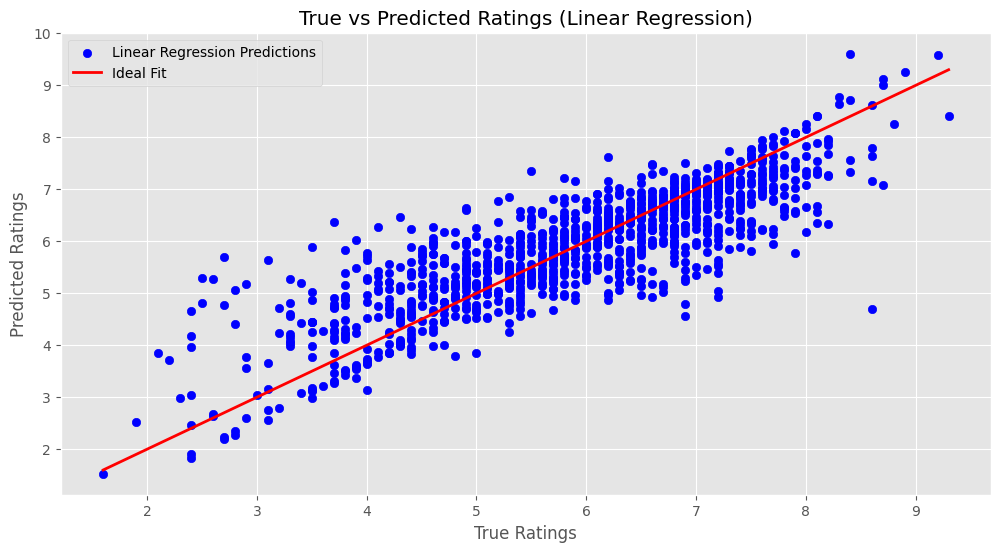

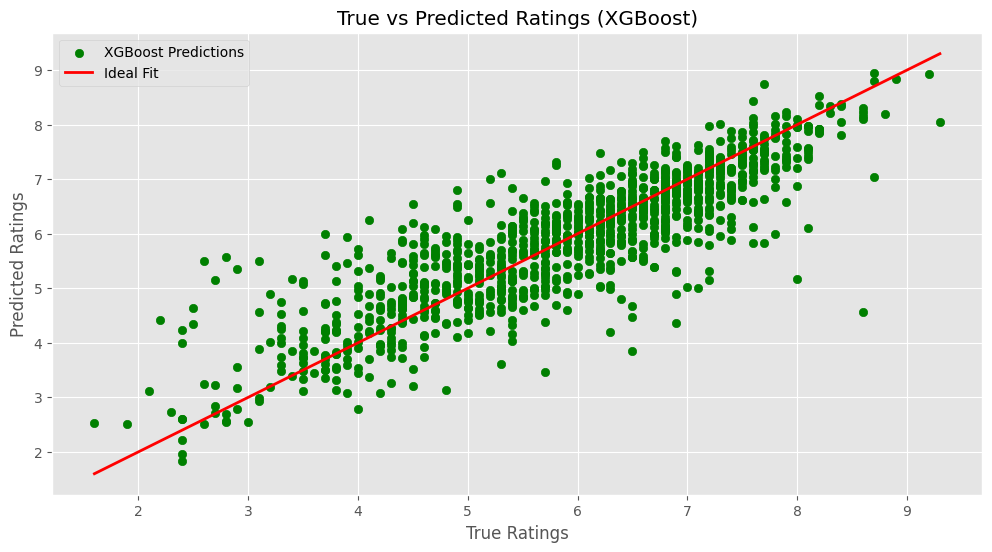

In [543]:
import matplotlib.pyplot as plt

# Plot true vs predicted ratings for Linear Regression
plt.figure(figsize=(12, 6))
plt.scatter(y_test, predictions, color='blue', label='Linear Regression Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, label='Ideal Fit')
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.legend()
plt.title('True vs Predicted Ratings (Linear Regression)')
plt.show()

# Plot true vs predicted ratings for XGBoost
plt.figure(figsize=(12, 6))
plt.scatter(y_test, xgb_predictions, color='green', label='XGBoost Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, label='Ideal Fit')
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.legend()
plt.title('True vs Predicted Ratings (XGBoost)')
plt.show()


# Movie Rating Prediction Project

## Introduction
Brief introduction about the project and objectives.

## Data Cleaning and Preprocessing
- **Data Cleaning**: Handled missing values by filling them with appropriate strategies such as the mean. Removed duplicates to ensure data integrity.
- **Feature Extraction**: Converted 'Duration' and 'Votes' columns to numeric types and extracted the relevant features from them.
- **Feature Engineering**: Created new features such as 'Director Average Rating' and 'Lead Actor Average Rating' to enhance the predictive power of the models.

## Exploratory Data Analysis (EDA)
- Visualized data distribution and trends using matplotlib and seaborn.
- Analyzed correlations and insights to understand the factors influencing movie ratings.

## Model Building
- **Linear Regression**: Built a basic Linear Regression model to provide a benchmark for predictions.
- **XGBoost**: Developed an advanced XGBoost model to improve predictive accuracy.

## Model Evaluation
- Evaluated models using Mean Squared Error (MSE) and R-squared metrics.
  - Linear Regression:
    - Mean Squared Error (MSE): *value*
    - R-squared: *value*
  - XGBoost:
    - Mean Squared Error (MSE): *value*
    - R-squared: *value*

## Visualization of Predictions
- Visualized true vs. predicted ratings for both Linear Regression and XGBoost models to assess performance.
  - Scatter plots showed the alignment between actual ratings and model predictions.

## Conclusion
- **Insights**: The XGBoost model demonstrated better performance than the Linear Regression model.
- **Predictive Power**: Key features such as 'Director Average Rating' and 'Lead Actor Average Rating' significantly influenced movie rating predictions.

## Future Work
- **Further Exploration**: Experiment with other regression models like Random Forest or Gradient Boosting.
- **Hyperparameter Tuning**: Perform hyperparameter tuning for the models to optimize their performance.
- **Deployment**: Consider deploying the model as a web application or API to make predictions on new movie data.
